# V - Supervised Subsampling with CAFI data - for DRC
### Run a supervised classification based on validated data from CAFI DDD for training, and subsample by KMeans-Neyman stratification
##### This script estimates a probability of forest change based on eSBAE variables, using CAFI validated data (2015-2020) as training. 
##### The change probability is then divided into 3 strata, which are proportionally sampled for validation
##### You can export samples as csv to create your own CEO project
##### This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc

import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


##### run this first I don't know why

In [ ]:
prov = "/home/sepal-user/data/drc/RDC_Province_26.shp"
# Read file using gpd.read_file()
prov_shp = gpd.read_file(prov)
prov_shp.head()

# 1 - CEO data preparation

## 1.1 - Import CEO interpreted data
Import the CEO validated data

### 13115 points, randomly distributed over CAFI, with interpretation

In [4]:
trn_ceo = pd.read_csv('/home/sepal-user/data/validation/all_ceo_validation_TMF_2023_uniqueID.csv', delimiter=',')
#trn_ceo = pd.read_csv('/home/sepal-user/data/validation/all_ceo_validation.csv', delimiter=',')
trn_ceo.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_ChDate,Change_Bin,UniqueID
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2018,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2020,1,2
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2020,1,3
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,4
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,5


### Load the corresponding augmented data set into a GDF

In [5]:
trn_gdf = py_helpers.geojson_to_gdf('/home/sepal-user/module_results/esbae/CAFI/04_Dataset_Augmentation/Landsat/1_change.geojson')
trn_gdf.columns

Index(['geometry', 'UniqueID', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri

In [6]:
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub']

Export as CSV (optional)

In [7]:
#csv_out_file =  '/home/sepal-user/module_results/esbae/CAFI/04_Dataset_Augmentation/Landsat/export_CAFI_esbae.csv'
#trn_gdf[cols_to_export].to_csv(csv_out_file)

In [8]:
len(trn_gdf.index)

13115

In [9]:
len(trn_ceo.index)

13115

In [10]:
trn_gdf = trn_gdf[cols_to_export]

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [11]:
trn_ceo.columns

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_ChDate', 'Change_Bin', 'UniqueID'],
      dtype='object')

In [12]:
#print(trn_ceo.duplicated(subset=['UniqueID']).value_counts())

In [13]:
trn_ceo['UniqueID'].nunique(dropna=False)

13115

In [14]:
#trn_gdf.columns

In [15]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [16]:
# show unique values for the columns (in red)
print('Change', trn_ceo['Ref_Change'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [17]:
# add CNC column for classification
trn_ceo['cnc_1520'] = trn_ceo['Ref_Change'].apply(lambda x: 1 if x == 'Def' or x == 'Deg'  else 0)
#ceo_df['cnc_1015'] = ceo_df['CHG_10_15'].apply(lambda x: 1 if x == 'Deforestation' else 0)
#ceo_df['CNC_ceo']  = ceo_df['cnc_0010'] + ceo_df['cnc_1015']

#trn_join.head(5)
np.unique(trn_ceo['cnc_1520'], return_counts=True)

(array([0, 1]), array([9275, 3840]))

In [18]:
trn_join = pd.merge(trn_ceo,trn_gdf, left_on='UniqueID', right_on='UniqueID',how='outer')
len(trn_join.index)

13115

# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data

In [19]:
# glob all files in the data augmentation output folder
files = Path('/home/sepal-user/module_results/esbae/DRC/04_Data_Augmentation/Landsat/').glob('*geojson')

# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

In [20]:
len(cdf.index)

1973273

In [21]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [22]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_l

In [23]:
print(trn_ceo.columns)

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_ChDate', 'Change_Bin', 'UniqueID', 'cnc_1520'],
      dtype='object')


### 2.1a - drop points which aren't within the forest mask (optional)
##### this is a way to focus validation in areas we are certain were forest in 2000, therefore reducing the need to validate non-forest areas

In [24]:
src = rasterio.open("/home/sepal-user/data/lc_map/forest_mask.tif")

In [25]:
coord_list = [(x, y) for x, y in zip(cdf["geometry"].x, cdf["geometry"].y)]

In [26]:
cdf["value"] = [x for x in src.sample(coord_list)]
cdf['value'] = cdf['value'].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,value
0,POINT (21.81460 3.17604),1786794,"[20100129, 20100809, 20100825, 20101231, 20111...","{'green': [775.0, 663.0, 522.5, 557.0, 512.0, ...",127,92,2016.082,-663.263855,-2.929723,2015.710,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
1,POINT (21.81970 3.18581),1786795,"[20100213, 20100520, 20101214, 20110115, 20110...","{'green': [309.0, 256.0, 357.0, 371.0, 344.5, ...",121,93,2017.721,328.460571,1.608799,2016.408,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
2,POINT (21.81425 3.15655),1786824,"[20100529, 20100809, 20100817, 20100825, 20101...","{'green': [352.0, 473.0, 397.0, 400.6666666666...",128,92,2015.512,-646.093933,-5.213411,2017.636,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
3,POINT (21.81935 3.16632),1786825,"[20100809, 20100825, 20101231, 20111108, 20111...","{'green': [708.0, 596.5, 608.0, 515.0, 451.5, ...",127,92,2015.512,-720.501404,-8.295720,2016.258,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1
4,POINT (21.81900 3.14683),1786858,"[20100529, 20100809, 20100817, 20100825, 20101...","{'green': [333.0, 568.0, 446.0, 538.6666666666...",121,87,2015.534,-342.082703,-3.743933,2020.244,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,1


In [27]:
select = cdf.loc[cdf['value'] == 1]

In [28]:
len(select.index)

1548365

In [29]:
select.drop(columns=['value'])

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2015,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub
0,POINT (21.81460 3.17604),1786794,"[20100129, 20100809, 20100825, 20101231, 20111...","{'green': [775.0, 663.0, 522.5, 557.0, 512.0, ...",127,92,2016.082,-663.263855,-2.929723,2015.710,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0
1,POINT (21.81970 3.18581),1786795,"[20100213, 20100520, 20101214, 20110115, 20110...","{'green': [309.0, 256.0, 357.0, 371.0, 344.5, ...",121,93,2017.721,328.460571,1.608799,2016.408,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0
2,POINT (21.81425 3.15655),1786824,"[20100529, 20100809, 20100817, 20100825, 20101...","{'green': [352.0, 473.0, 397.0, 400.6666666666...",128,92,2015.512,-646.093933,-5.213411,2017.636,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0
3,POINT (21.81935 3.16632),1786825,"[20100809, 20100825, 20101231, 20111108, 20111...","{'green': [708.0, 596.5, 608.0, 515.0, 451.5, ...",127,92,2015.512,-720.501404,-8.295720,2016.258,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0
4,POINT (21.81900 3.14683),1786858,"[20100529, 20100809, 20100817, 20100825, 20101...","{'green': [333.0, 568.0, 446.0, 538.6666666666...",121,87,2015.534,-342.082703,-3.743933,2020.244,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,POINT (28.03951 -5.71153),3192557,"[20100126, 20100331, 20100424, 20100510, 20100...","{'green': [471.0, 548.0, 484.5, 447.3333333333...",199,146,2016.425,828.344177,2.950681,2015.329,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1996.0,20.0,23.0
24995,POINT (28.03970 -5.73161),3192655,"[20100126, 20100211, 20100331, 20100424, 20100...","{'green': [473.0, 453.5, 513.5, 493.0, 468.666...",207,147,2015.636,438.452393,2.415811,2017.386,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2005.0,20.0,26.0
24997,POINT (28.02521 -5.72126),3192456,"[20100126, 20100211, 20100424, 20100518, 20100...","{'green': [585.0, 600.5, 512.0, 540.0, 525.0, ...",195,142,2015.701,-2267.835205,-3.765563,2019.490,...,6.0,6.0,6.0,6.0,6.0,6.0,0.0,0.0,70.0,91.0
24998,POINT (28.03462 -5.70139),3192458,"[20100126, 20100211, 20100424, 20100510, 20100...","{'green': [770.0, 679.0, 554.0, 549.5, 591.0, ...",207,145,2017.342,-2711.031006,-2.578475,2019.447,...,6.0,6.0,6.0,6.0,6.0,6.0,0.0,0.0,70.0,91.0


In [30]:
cdf = select
len(cdf.index)

1548365

### 2.2 - Make a union with training data

In [31]:
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub']

In [32]:
harm_cols = eSBAE_cols + ['geometry','point_id','cnc_1520']
#cols_to_harmonize

In [33]:
#cdf['UniqueID'] = 0
cdf['cnc_1520'] = float('nan')
trn_join['point_id']= 0

db = pd.concat([cdf[harm_cols],trn_join[harm_cols]])

In [34]:
len(db.index)

1561480

In [35]:
trn_join.head(2)

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,point_id
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,6.0,6.0,6.0,6.0,6.0,0.0,0.0,70.0,91.0,0
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,6.0,6.0,6.0,6.0,6.0,0.0,0.0,70.0,91.0,0


In [36]:
db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [37]:
len(cdf.index)+len(trn_join.index) == len(db.index)

True

### 2.3 Check the amount of ground truth data we have for each class

In [38]:
np.unique(db['cnc_1520'], return_counts=True)

(array([ 0.,  1., nan]), array([   9275,    3840, 1548365]))

### Run change/no-change classification

In [39]:
# predictors used change/nochange classification
db['chg_prob'] = clf.binary_probability_classification(db, 'cnc_1520', eSBAE_cols, outlier=False)

OOB Score is 0.7862752573389249


In [40]:
clf_db = db[db["point_id"] > 0]

array([<Axes: title={'center': 'chg_prob'}>], dtype=object)

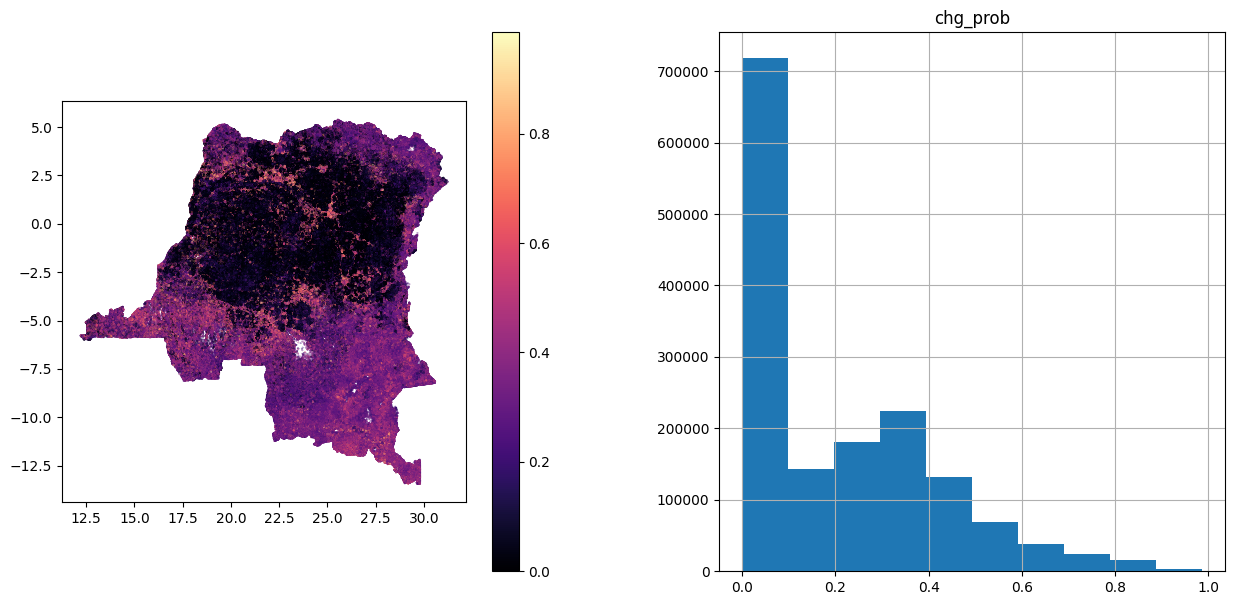

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob', ax=ax[1])

In [42]:
clf_db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [43]:
joined_df = clf_db

### Combine probs from Change and Forest

In [44]:
joined_df['simple_combined'] = joined_df['chg_prob']

#joined_df.apply(lambda row: update(row.fnf_max_prob, row.chg_prob), axis=1)
#joined_df['multiplied'] = joined_df.fnf_max_prob * joined_df.chg_prob

In [45]:
len(joined_df)

1548365

In [46]:
joined_df

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,...,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,cnc_1520,chg_prob,simple_combined
0,127,92,2016.082,-663.263855,-2.929723,2015.710,0.516891,5808.547516,9673.072153,264.749422,...,1.0,0.0,0.0,10.0,10.0,POINT (21.81460 3.17604),1786794,NaN,0.037333,0.037333
1,121,93,2017.721,328.460571,1.608799,2016.408,0.064274,1201.461111,9954.327778,104.017425,...,1.0,0.0,0.0,10.0,10.0,POINT (21.81970 3.18581),1786795,NaN,0.061333,0.061333
2,128,92,2015.512,-646.093933,-5.213411,2017.636,0.427163,5255.813768,9652.822283,275.581389,...,1.0,0.0,0.0,10.0,10.0,POINT (21.81425 3.15655),1786824,NaN,0.019333,0.019333
3,127,92,2015.512,-720.501404,-8.295720,2016.258,0.105731,2415.789493,9715.193219,191.880403,...,1.0,0.0,0.0,10.0,10.0,POINT (21.81935 3.16632),1786825,NaN,0.019333,0.019333
4,121,87,2015.534,-342.082703,-3.743933,2020.244,0.354583,3881.995676,9718.401122,240.410580,...,1.0,0.0,0.0,10.0,10.0,POINT (21.81900 3.14683),1786858,NaN,0.003333,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,199,146,2016.425,828.344177,2.950681,2015.329,0.559893,14882.345695,9182.997293,464.410634,...,2.0,0.0,1996.0,20.0,23.0,POINT (28.03951 -5.71153),3192557,NaN,0.180667,0.180667
24995,207,147,2015.636,438.452393,2.415811,2017.386,0.409592,12220.086386,9538.767647,509.549581,...,2.0,0.0,2005.0,20.0,26.0,POINT (28.03970 -5.73161),3192655,NaN,0.287333,0.287333
24997,195,142,2015.701,-2267.835205,-3.765563,2019.490,0.113805,47112.204435,6805.522493,2884.206807,...,6.0,0.0,0.0,70.0,91.0,POINT (28.02521 -5.72126),3192456,NaN,0.411333,0.411333
24998,207,145,2017.342,-2711.031006,-2.578475,2019.447,0.178289,106030.513227,2635.555443,5953.348921,...,6.0,0.0,0.0,70.0,91.0,POINT (28.03462 -5.70139),3192458,NaN,0.324000,0.324000


### Stratify with Kmeans

In [47]:
sample_size_no = 10000

In [48]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob', strata=3, sample_size=sample_size_no)

In [49]:
joined_df['kmeans'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,846722,0.048045,0.046057,38997.238579,1,3982,5468
1,527570,0.324930,0.073274,38657.147988,2,3947,3407
2,174073,0.611982,0.116447,20270.227639,3,2069,1124


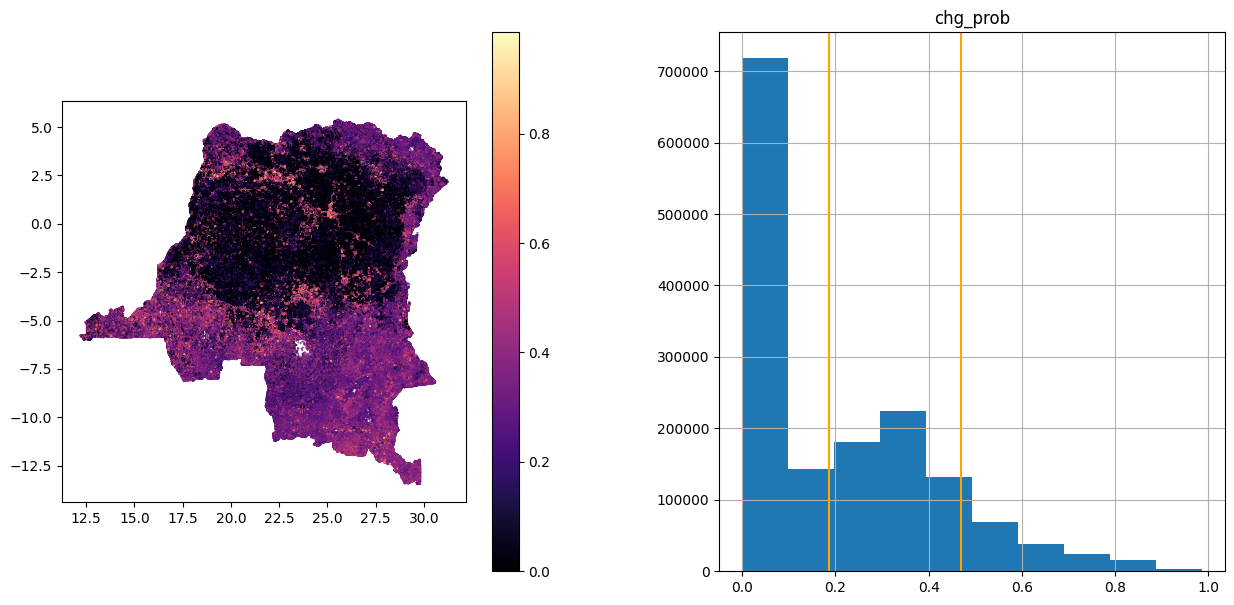

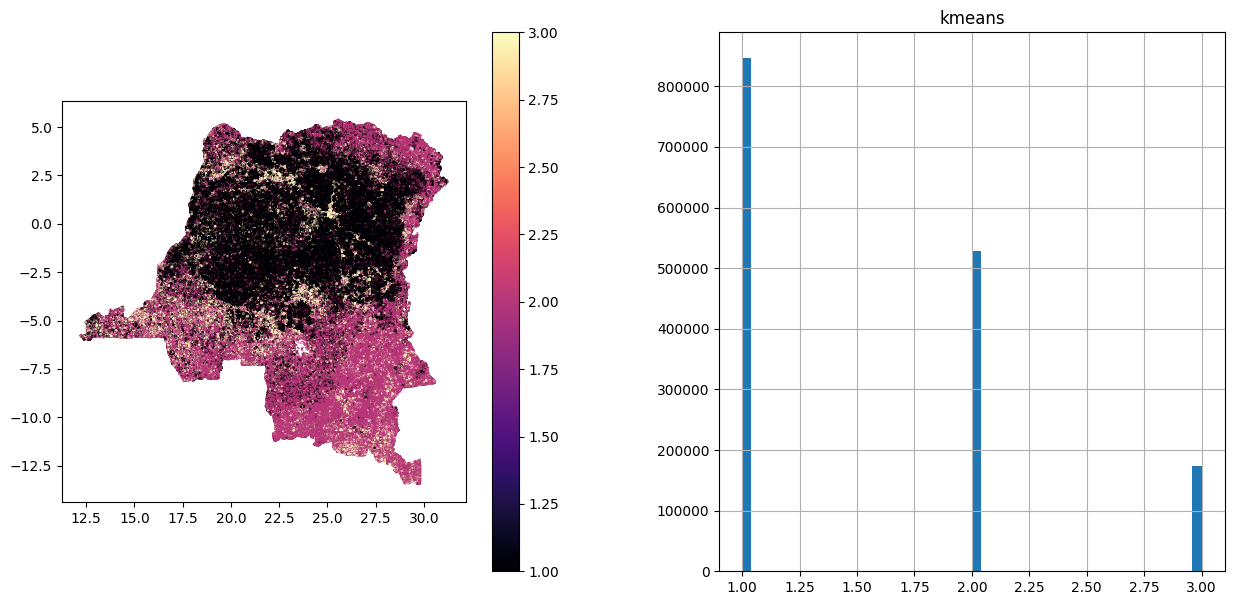

In [50]:
h.plot_cluster(joined_df, prob_column='chg_prob', strata_column='kmeans')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans', ax=ax[1], bins=50)
samples

In [51]:
joined_df['PLOTID'] = joined_df['point_id']

In [52]:
joined_df.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [53]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

## add DRC provinces

In [ ]:
joined_gdf = geopandas.GeoDataFrame(
    joined_df, geometry=geopandas.points_from_xy(joined_df.LON, joined_df.LAT), crs="EPSG:4326"
)

In [ ]:
prov_polygon = prov_shp.to_crs(joined_gdf.crs.to_dict()) 

In [ ]:
joined_gdf_prov = gpd.sjoin(left_df=joined_gdf, right_df=prov_polygon, how='left') #Left or polygons with zero points are discarded
joined_gdf_prov

#### export model file with province names (optional)

In [ ]:
points_out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_all_points_2015_2022_model.csv'
joined_gdf_prov.to_csv(points_out_file,index=False)

### now proceed to script 5b if you want to select samples for validation with CEO